#0. lib import, 데이터 로드

In [2]:
!pip install scikit_posthocs # 사후분석
!pip install pingouin #ANOVA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 13.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import scipy as sp
import numpy as np
import pingouin as pg
import scikit_posthocs

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
src_path =  'https://codepresso-online-platform-public.s3.ap-northeast-2.amazonaws.com/learning-resourse/python_da/sns_usage_time.csv'
df = pd.read_csv(src_path, sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age_grp   6000 non-null   object 
 1   rank      6000 non-null   int64  
 2   use_time  6000 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 140.8+ KB


#1. One-way ANOVA

* 문제
  * 연령대별 SNS사용기간이 통계적으로 유의한 차이가 있는지 검정

* 가설설정
  * H0 : 연령별 SNS 사용시간의 평균의 차이(=분산의 차이)는 없다
  * H1 : 연령별 SNS 사용시간의 평균의 차이(=분산의 차이)가 적어도 하나의 연령대에서 차이가 있을 것이다.

In [5]:
df['age_grp'].value_counts()

,count
age_grp,
30,1000
20,1000
50,1000
10 and under,1000
60 and over,1000
40,1000


In [6]:
df.sort_values(by='age_grp',inplace=True)

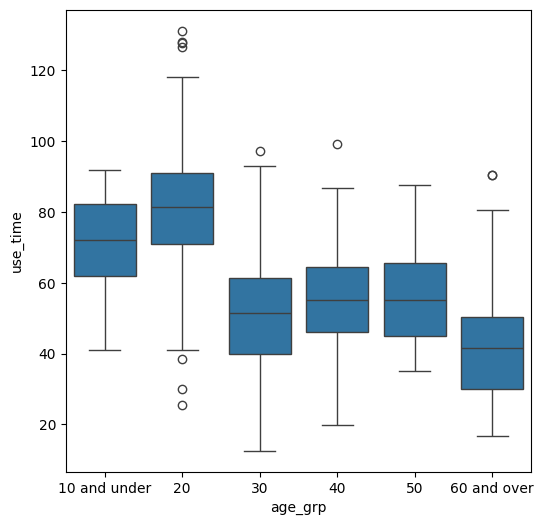

In [8]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()
sns.boxplot( x='age_grp', y='use_time',
            data=df, ax=ax)
plt.show()

In [10]:
#PANDAS LIB.의 결과가 소수점 셋째 자리까지 출력이 되도록 설정
pd.options.display.float_format='{:.3f}'.format

1. 등분산 검정

* H0 : 등분산이다
* H1 : 등분산이 아니다

In [13]:
np_arr_type_10=np.array(df.loc[df['age_grp']=='10 and under']['use_time'])
np_arr_type_20=np.array(df.loc[df['age_grp']=='20']['use_time'])
np_arr_type_30=np.array(df.loc[df['age_grp']=='30']['use_time'])
np_arr_type_40=np.array(df.loc[df['age_grp']=='40']['use_time'])
np_arr_type_50=np.array(df.loc[df['age_grp']=='50']['use_time'])
np_arr_type_60=np.array(df.loc[df['age_grp']=='60 and over']['use_time'])

* pvalue > 유의수준(0.05) -> H1 기각 = 등분산이다.

==> 등분산 : ANOVA <-> 이분산 : welch-ANOVA

In [14]:
print(sp.stats.bartlett(
    np_arr_type_10,
    np_arr_type_20,
    np_arr_type_30,
    np_arr_type_40,
    np_arr_type_50,
    np_arr_type_60
))

BartlettResult(statistic=9.831118547662085, pvalue=0.0801643178333404)


2. ANOVA

* p-unc : p-value
* ddof1 : 집단간 분산의 자유도(c-1)
* ddof2 : 집단내 분산의 자유도(전체자료수-집단수)
* dv : 종속변수
* between : 독립변수

In [15]:
pg.anova(dv='use_time', between ='age_grp', data=df)

,Source,ddof1,ddof2,F,p-unc,np2
0,age_grp,5,5994,1505.239,0.000,0.557


p-value<유의수준 : H1 채택

==> 무엇이 기존과 떨어져 있는지 확인해야하므로 사후분석 실행

3. 사후분석

In [17]:
from statsmodels.stats.multicomp import MultiComparison

In [19]:
mc = MultiComparison(data =df['use_time'], groups =df ['age_grp'])
print(mc.tukeyhsd())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2   meandiff p-adj  lower    upper   reject
----------------------------------------------------------------
10 and under          20   9.1838   0.0   7.6509  10.7166   True
10 and under          30 -21.0019   0.0 -22.5347  -19.469   True
10 and under          40 -16.8189   0.0 -18.3518 -15.2861   True
10 and under          50 -16.7355   0.0 -18.2684 -15.2027   True
10 and under 60 and over -31.2949   0.0 -32.8277  -29.762   True
          20          30 -30.1857   0.0 -31.7185 -28.6528   True
          20          40 -26.0027   0.0 -27.5356 -24.4698   True
          20          50 -25.9193   0.0 -27.4522 -24.3864   True
          20 60 and over -40.4786   0.0 -42.0115 -38.9458   True
          30          40    4.183   0.0   2.6501   5.7158   True
          30          50   4.2664   0.0   2.7335   5.7992   True
          30 60 and over  -10.293   0.0 -11.8258  -8.7601   True
          40          50 

**reject**

* H0을 기각할지 말지
  * True : 기각 o
  * False : 기각 x

위에서는 40대와 50대를 제외하고 평균의 차이가 존재함을 알 수 있다.